In [1]:
import pandas as pd
import torch
import numpy as np

# Load dataset
file_path = 'final_merge_Greece (1).csv'
df = pd.read_csv(file_path, delimiter='|')
df.columns = df.columns.str.strip()
df.rename(columns={df.columns[0]: 'Index'}, inplace=True)

# Handle date-time conversion
df['Date Time'] = pd.to_datetime(df['Date Time'], errors='coerce')
df.dropna(subset=['Date Time'], inplace=True)

# Extract relevant data
timestamps = df['Date Time'].astype(np.int64) // 10**9
latitudes = df['latitude'].to_numpy()
longitudes = df['longitude'].to_numpy()
magnitudes = df['magnitude'].to_numpy()

# Normalize time in days
time_in_days = ((timestamps - timestamps.min()) / 86400).astype(np.float32)

# Move data to GPU
device = torch.device('cuda')
times_tensor = torch.tensor(time_in_days, dtype=torch.float32, device=device)
lat_tensor = torch.tensor(latitudes, dtype=torch.float32, device=device)
lon_tensor = torch.tensor(longitudes, dtype=torch.float32, device=device)
mag_tensor = torch.tensor(magnitudes, dtype=torch.float32, device=device)

# Haversine function (GPU-compatible)
def compute_haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6371.0  # in kilometers
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = torch.sin(delta_lat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(delta_lon / 2) ** 2
    c = 2 * torch.arcsin(torch.sqrt(a))
    return earth_radius * c

# Metric parameters
b = 1.0
q = 0.5
batch_size = 600
total_events = len(df)
eta_min_list = []

# Convert coordinates to radians
lat_rad = torch.deg2rad(lat_tensor)
lon_rad = torch.deg2rad(lon_tensor)

# Compute Zaliapin metric in batches
for start_idx in range(0, total_events, batch_size):
    torch.cuda.empty_cache()
    end_idx = min(start_idx + batch_size, total_events)
    print(f"Processing records from {start_idx} to {end_idx}")

    # Slice batch data
    t_batch = times_tensor[start_idx:end_idx].unsqueeze(1)
    lat_batch = lat_rad[start_idx:end_idx].unsqueeze(1)
    lon_batch = lon_rad[start_idx:end_idx].unsqueeze(1)
    mag_batch = mag_tensor[start_idx:end_idx].unsqueeze(1)

    # Compute temporal and spatial distances
    dt = torch.abs(t_batch - times_tensor)
    delta_lat = lat_rad - lat_batch
    delta_lon = lon_rad - lon_batch
    a = torch.sin(delta_lat / 2) ** 2 + torch.cos(lat_batch) * torch.cos(lat_rad) * torch.sin(delta_lon / 2) ** 2
    c = 2 * torch.arcsin(torch.sqrt(a))
    distance = 6371.0 * c

    # Calculate eta metric
    eta = distance / (10 ** (-b * mag_batch)) * (dt ** q)

    # Prevent self-comparison within batch
    eta[:, start_idx:end_idx] = float('inf')

    # Store minimum eta values for batch
    eta_min_batch = torch.min(eta, dim=1).values
    eta_min_list.append(eta_min_batch.cpu().numpy())

    # Free GPU memory
    del dt, delta_lat, delta_lon, a, c, distance, eta
    torch.cuda.empty_cache()

# Combine all eta_min values
eta_min = np.concatenate(eta_min_list)
df['eta_min'] = eta_min

# Save selected columns to CSV
output_columns = ['Date Time', 'latitude', 'longitude', 'depth', 'magnitude', 'eta_min']
df[output_columns].to_csv('/content/declustered_result.csv', index=False)

# Preview result
df[output_columns].head()

<ipython-input-1-13c575faa152>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date Time'] = pd.to_datetime(df['Date Time'], errors='coerce')


Processing records from 0 to 600
Processing records from 600 to 1200
Processing records from 1200 to 1800
Processing records from 1800 to 2400
Processing records from 2400 to 3000
Processing records from 3000 to 3600
Processing records from 3600 to 4200
Processing records from 4200 to 4800
Processing records from 4800 to 5400
Processing records from 5400 to 6000
Processing records from 6000 to 6600
Processing records from 6600 to 7200
Processing records from 7200 to 7800
Processing records from 7800 to 8400
Processing records from 8400 to 9000
Processing records from 9000 to 9600
Processing records from 9600 to 10200
Processing records from 10200 to 10800
Processing records from 10800 to 11400
Processing records from 11400 to 12000
Processing records from 12000 to 12600
Processing records from 12600 to 13200
Processing records from 13200 to 13800
Processing records from 13800 to 14400
Processing records from 14400 to 15000
Processing records from 15000 to 15600
Processing records from 

,Date Time,latitude,longitude,depth,magnitude,eta_min
0,1964-02-24 23:30:25,38.90,23.90,10,5.3,0.0
1,1964-04-11 16:00:00,39.75,25.25,10,5.7,0.0
2,1964-04-21 08:14:40,38.50,22.25,10,4.5,0.0
3,1964-04-24 03:49:58,38.00,21.80,10,5.0,0.0
4,1964-04-29 04:21:00,39.25,23.75,10,5.8,0.0


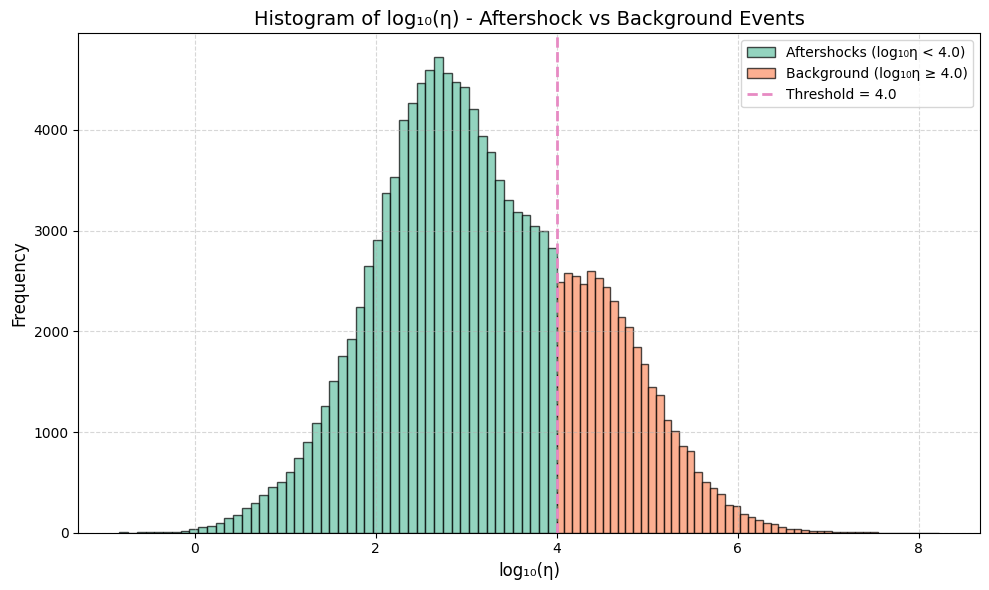

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read declustered output
data = pd.read_csv("declustered_result.csv")

# Filter out invalid or missing eta_min values
data = data.dropna(subset=["eta_min"])
eta = data["eta_min"].to_numpy()
log_eta = np.log10(eta[eta > 0])  # Avoid log(0) or negative

# Classification based on threshold
threshold_value = 4.0
clustered_events = log_eta[log_eta < threshold_value]
independent_events = log_eta[log_eta >= threshold_value]

# Plot setup
plt.figure(figsize=(10, 6))

# Use a new color scheme
plt.hist(clustered_events, bins=50, color='#66c2a5', alpha=0.7,
         edgecolor='black', label='Aftershocks (log₁₀η < 4.0)')
plt.hist(independent_events, bins=50, color='#fc8d62', alpha=0.7,
         edgecolor='black', label='Background (log₁₀η ≥ 4.0)')

# Threshold line
plt.axvline(threshold_value, color='#e78ac3', linestyle='--',
            linewidth=2, label=f'Threshold = {threshold_value}')

# Labels and title
plt.xlabel("log₁₀(η)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of log₁₀(η) - Aftershock vs Background Events", fontsize=14)

# Decorations
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
